Benchmarking results files must be placed in the following manner:

```
- benchmarking-results
  - json-accuracy
    - llm-img2json
      - model
        - llm-img2json_<cleaning_method>_<time_str>.csv
        - ...
    - llm-txt2json
      - model
        - llm-txt2json_<cleaning_method>_<time_str>.csv
        - ...
  - txt-accuracy
    - llm-img2txt
      - model
        - <cleaning_method>_<time_str>.csv
        - ...
    - ocr-img2txt
      - ...
    - ocr-llm-img2txt
      - ...
```    

# Open multiple results files using Pandas

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

ROOT_DIR = Path.cwd().parent.parent

# For reference only
TXT_PARENT_DIR = ROOT_DIR / 'benchmarking-results' / 'txt-accuracy'
TXT_SUB_DIRS = ['llm-img2txt', 'ocr-img2txt', 'ocr-llm-img2txt']

JSON_PARENT_DIR = ROOT_DIR / 'benchmarking-results' / 'json-accuracy'
JSON_SUB_DIRS = ['llm-img2json', 'llm-txt2json']

def process_dfs(df: pd.DataFrame, sub_dir: str, filename: str) -> pd.DataFrame:
        """
        Returns a new dataframe with the following operations applied:
        - Adds the column `sub_dir`, which is the subdirectory the file is located in (i.e. img2json) found from the sub_dir parameter.
        - Adds the column `cleaning_method`, which contains either 'normalized', 'nonorm', or 'fuzzy' found from the cleaning_method parameter.
        - Adds the column `time_str`, which is a string representing the time of file creation found from the name parameter.
        - Splits the previously-unnamed column into a `doc` and `metric` column
        """
        old_cols = list(df.columns)
        new_cols = ["sub_dir", "cleaning_method", "time_str", "doc", "metric"] + old_cols

        # Filename format: assume the following; others are invalid
        # - llm-img2json_<cleaning_method>_<time_str>.csv
        # - llm-txt2json_<cleaning_method>_<time_str>.csv
        # - <cleaning_method>_<time_str>.csv

        filename_split = filename.split("_")
        cleaning_method = "_".join(filename_split[:-2]).removeprefix("llm-img2json_").removeprefix("llm-txt2json_")
        time_str = "_".join(filename_split[-2:]).removesuffix(".csv")

        processed_df = df.copy()
        processed_df["sub_dir"] = sub_dir
        processed_df["cleaning_method"] = cleaning_method
        processed_df["time_str"] = time_str
        processed_df["doc"] = processed_df["Unnamed: 0"].apply(lambda x: (x.split(":")[0]))
        processed_df["metric"] = processed_df["Unnamed: 0"].apply(lambda x: ":".join(x.split(":")[1:]))
        processed_df = processed_df[new_cols]
        processed_df = processed_df.drop(columns="Unnamed: 0")

        return processed_df


def open_benchmarking_results_folder(parent_dir: Path, sub_dir: str) -> pd.DataFrame:
    """
    Opens all of the benchmarking results within a single directory following the specified parameters.
    `search_pattern` is handled using glob.

    Returns a list with dataframes.
    """

    file_paths = (parent_dir / sub_dir).glob('*.csv')
    dataframes = [
        process_dfs(
            pd.read_csv(parent_dir / sub_dir / path), sub_dir, path.name
        ) for path in file_paths
    ]

    combined = pd.concat(dataframes, ignore_index=True)
    return combined


def open_all_benchmarking_results(parent_dir: Path, sub_dirs: list[str]):
    """
    Opens all of the benchmarking results for either text or JSON output.

    Returns a combined dataframe.
    """
    dataframes = [
        open_benchmarking_results_folder(parent_dir, sub_dir) for sub_dir in sub_dirs
    ]
    combined = pd.concat(dataframes, ignore_index=True)
    return combined


txt_bm = open_all_benchmarking_results(TXT_PARENT_DIR, TXT_SUB_DIRS)
json_bm = open_all_benchmarking_results(JSON_PARENT_DIR, JSON_SUB_DIRS)

# Text benchmarking results

In [116]:
txt_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,dist_char,6.000000,8.000000,NaN
1,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,doc_len,2584.000000,2584.000000,NaN
2,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,cer_pct,0.232198,0.309598,NaN
3,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,wer_pct,0.427350,0.641026,NaN
4,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,token_sort_ratio,99.883766,99.845141,NaN
...,...,...,...,...,...,...,...,...
5275,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,dist_char,13979.000000,2663.000000,NaN
5276,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,doc_len,156416.000000,156416.000000,NaN
5277,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,cer_pct,8.937065,1.702511,NaN
5278,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,wer_pct,11.933058,4.337457,NaN


## Move pytesseract results alongside LLM results

In [117]:
# Split txt results to (llm-img2txt + ocr-llm-img2txt) and (ocr-img2txt)
llm_txt_results = txt_bm[txt_bm['sub_dir'] != 'ocr-img2txt']
ocr_txt_results = txt_bm[txt_bm['sub_dir'] == 'ocr-img2txt']

# Fill in llm-img2txt columns
for index, row in llm_txt_results.iterrows():
    cleaning_method = row['cleaning_method']
    time_str = row['time_str']
    doc = row['doc']
    metric = row['metric']

    ocr_metric = ocr_txt_results.loc[
        (ocr_txt_results['cleaning_method'] == cleaning_method) &
        (ocr_txt_results['time_str'] == time_str) &
        (ocr_txt_results['doc'] == doc) &
        (ocr_txt_results['metric'] == metric),
        'pytesseract'
    ]
    if not ocr_metric.empty:
        llm_txt_results.loc[index, 'pytesseract'] = ocr_metric.iloc[0]

llm_txt_results

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,dist_char,6.000000,8.000000,2584.000000
1,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,doc_len,2584.000000,2584.000000,2584.000000
2,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,cer_pct,0.232198,0.309598,100.000000
3,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,wer_pct,0.427350,0.641026,100.000000
4,llm-img2txt,normalized,2025-07-15_10-04-09,kbaa-p003,token_sort_ratio,99.883766,99.845141,0.000000
...,...,...,...,...,...,...,...,...
5275,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,dist_char,13979.000000,2663.000000,156407.000000
5276,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,doc_len,156416.000000,156416.000000,156416.000000
5277,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,cer_pct,8.937065,1.702511,99.994246
5278,ocr-llm-img2txt,nonorm,2025-07-15_10-10-29,__ALL__,wer_pct,11.933058,4.337457,99.995958


# Calculate metrics

In [118]:
txt_all_docs = llm_txt_results['doc'] == '__ALL__'
txt_error_rates = (
    (llm_txt_results['metric'] == 'cer_pct') |
    (llm_txt_results['metric'] == 'wer_pct') |
    (llm_txt_results['metric'] == 'token_sort_ratio')
)

In [119]:
llm_txt_results_grouped = llm_txt_results[~txt_all_docs].drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
llm_txt_results_grouped_mean = llm_txt_results_grouped.mean()
llm_txt_results_grouped_mean

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   4.995616   
                                dist_char               182.209302   
                                doc_len                3636.604651   
                                token_sort_ratio         98.640833   
                                wer_pct                   8.135123   
                normalized      cer_pct                   3.899890   
                                dist_char               128.965116   
                                doc_len                3298.767442   
                                token_sort_ratio         99.273208   
                                wer_pct                   4.772172   
ocr-llm-img2txt nonorm          cer_pct                   6.514373   
                                dist_char               237.715116   
                                doc_len                3636.604651   
                                token_sort_ratio         98.338936   
                                wer_pct                   9.144679   
                normalized      cer_pct                   5.236978   
                                dist_char               173.558140   
                                doc_len                3298.767442   
                                token_sort_ratio         98.977038   
                                wer_pct                   6.447015   

                                                       gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                      
llm-img2txt     nonorm          cer_pct              2.592274    55.508686  
                                dist_char           95.075581  2018.651163  
                                doc_len           3636.604651  3636.604651  
                                token_sort_ratio    98.562797    48.548092  
                                wer_pct              4.870222    58.330432  
                normalized      cer_pct              2.036268    54.389018  
                                dist_char           67.779070  1794.313953  
                                doc_len           3298.767442  3298.767442  
                                token_sort_ratio    99.167550    49.142259  
                                wer_pct              2.533852    56.221166  
ocr-llm-img2txt nonorm          cer_pct              1.892801    55.508686  
                                dist_char           68.959302  2018.651163  
                                doc_len           3636.604651  3636.604651  
                                token_sort_ratio    98.617608    48.548092  
                                wer_pct              4.414858    58.330432  
                normalized      cer_pct              1.470008    54.389018  
                                dist_char           48.616279  1794.313953  
                                doc_len           3298.767442  3298.767442  
                                token_sort_ratio    99.265592    49.142259  
                                wer_pct              1.603840    56.221166

In [120]:
llm_txt_results_grouped_std = llm_txt_results_grouped.std()
llm_txt_results_grouped_std

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   5.638417   
                                dist_char               206.892130   
                                doc_len                 138.465802   
                                token_sort_ratio          1.034558   
                                wer_pct                   6.020446   
                normalized      cer_pct                   5.283893   
                                dist_char               174.503000   
                                doc_len                 135.274093   
                                token_sort_ratio          0.522011   
                                wer_pct                   5.845373   
ocr-llm-img2txt nonorm          cer_pct                   7.643528   
                                dist_char               284.087799   
                                doc_len                 138.465802   
                                token_sort_ratio          2.675819   
                                wer_pct                   8.469912   
                normalized      cer_pct                   7.363243   
                                dist_char               248.726610   
                                doc_len                 135.274093   
                                token_sort_ratio          2.551348   
                                wer_pct                   8.197151   

                                                      gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                     
llm-img2txt     nonorm          cer_pct             2.652315    45.219420  
                                dist_char          98.259533  1647.394780  
                                doc_len           138.465802   138.465802  
                                token_sort_ratio    1.048447    48.688705  
                                wer_pct             3.095805    42.646034  
                normalized      cer_pct             2.158127    46.329716  
                                dist_char          72.422558  1531.240687  
                                doc_len           135.274093   135.274093  
                                token_sort_ratio    0.581792    49.279428  
                                wer_pct             2.821351    44.748885  
ocr-llm-img2txt nonorm          cer_pct             1.373520    45.219420  
                                dist_char          50.046920  1647.394780  
                                doc_len           138.465802   138.465802  
                                token_sort_ratio    1.023413    48.688705  
                                wer_pct             2.209926    42.646034  
                normalized      cer_pct             1.112946    46.329716  
                                dist_char          36.695258  1531.240687  
                                doc_len           135.274093   135.274093  
                                token_sort_ratio    0.420642    49.279428  
                                wer_pct             1.311601    44.748885

Note: we can also group only the "\__ALL__" results which would give us differences between each run.

# JSON benchmarking results

In [121]:
json_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o
0,llm-img2json,nonorm,2025-07-14_15-43-07,kbaa-p003,__COL__:lastname,19,18
1,llm-img2json,nonorm,2025-07-14_15-43-07,kbaa-p003,__COL__:firstname,19,17
2,llm-img2json,nonorm,2025-07-14_15-43-07,kbaa-p003,__COL__:maidenname,19,19
3,llm-img2json,nonorm,2025-07-14_15-43-07,kbaa-p003,__COL__:birthyear,19,19
4,llm-img2json,nonorm,2025-07-14_15-43-07,kbaa-p003,__COL__:deathyear,18,19
...,...,...,...,...,...,...,...
20749,llm-txt2json,normalized,2025-07-14_15-43-07,kbaa-p121,__COL__:publishyear,NaN,22
20750,llm-txt2json,normalized,2025-07-14_15-43-07,kbaa-p121,__COL__:pagecount,NaN,22
20751,llm-txt2json,normalized,2025-07-14_15-43-07,kbaa-p121,__COL__:library,NaN,22
20752,llm-txt2json,normalized,2025-07-14_15-43-07,kbaa-p121,__COL__:description,NaN,22


In [122]:
json_only_all_docs = json_bm['doc'] == '__ALL__'
json_only_cols = json_bm['metric'].str.contains(r'__COL__:', regex=True)
json_only_int_results = (json_bm['metric'] != 'matches_pct') & (json_bm['metric'] != 'mismatch_bool')

Sums:

In [123]:
json_bm_int_all = json_bm[json_only_all_docs & json_only_int_results]
json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')
json_bm_int_all_grouped = json_bm_int_all.drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
json_bm_int_all_grouped.sum()

/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_31011/1168393538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_31011/1168393538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')


gemini-2.5-flash  gpt-4o
sub_dir      cleaning_method metric                                        
llm-img2json fuzzy           __COL__:birthyear                 3197    2487
                             __COL__:city                      3140    2397
                             __COL__:deathyear                 3248    2622
                             __COL__:description               2866    2233
                             __COL__:firstname                 3085    2412
...                                                             ...     ...
llm-txt2json normalized      matches                          37938   33626
                             mismatched_dim_count                17      26
                             pred_adj_nrows                    3509    3433
                             pred_nrows                        3445    3370
                             total                            41223   38675

[120 rows x 2 columns]

# Bar charts of aggregated results

In [124]:
# Utility functions for retrieving results with less typing
def grouped_mask(df, sub_dir, cleaning_method, metric):
    return (
        (df['sub_dir'] == sub_dir) &
        (df['cleaning_method'] == cleaning_method) &
        (df['metric'] == metric)
    )

gemini-2.5-flash     4.995616
gpt-4o               2.592274
pytesseract         55.508686
Name: (llm-img2txt, nonorm, cer_pct), dtype: float64


(48.0, 100.0)

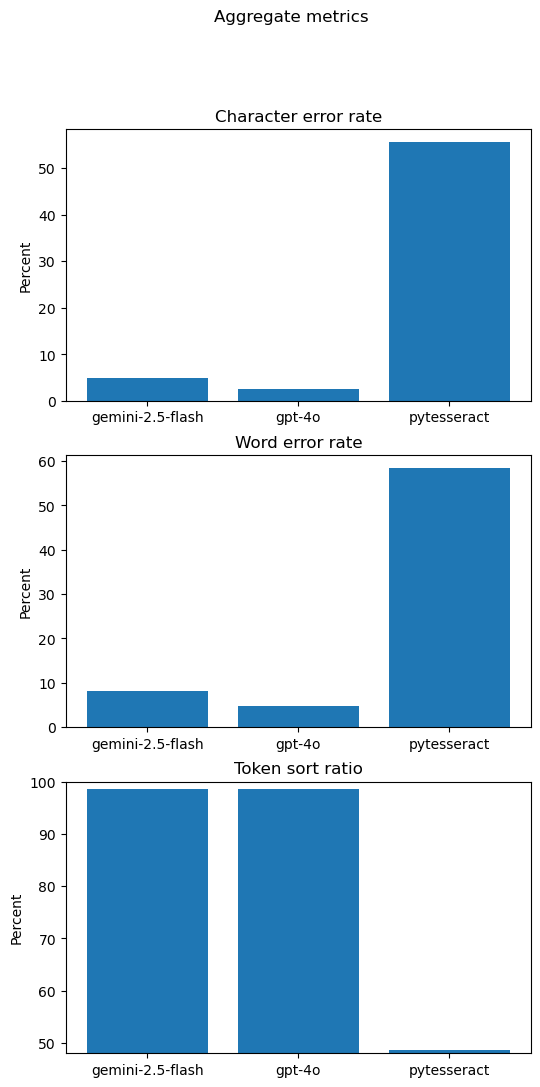

In [138]:
fig, (cer_ax, wer_ax, tsr_ax) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

cer_pct = llm_txt_results_grouped_mean.loc['llm-img2txt', 'nonorm', 'cer_pct']
wer_pct = llm_txt_results_grouped_mean.loc['llm-img2txt', 'nonorm', 'wer_pct']
tsr_pct = llm_txt_results_grouped_mean.loc['llm-img2txt', 'nonorm', 'token_sort_ratio']
models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

print(cer_pct)

fig.suptitle('Aggregate metrics')

cer_ax.bar(models, cer_pct)
cer_ax.set_title('Character error rate')
cer_ax.set_ylabel('Percent')
wer_ax.bar(models, wer_pct)
wer_ax.set_title('Word error rate')
wer_ax.set_ylabel('Percent')
tsr_ax.bar(models, tsr_pct)
tsr_ax.set_title('Token sort ratio')
tsr_ax.set_ylabel('Percent')
tsr_ax.set_ylim(np.floor(np.min(tsr_pct)), 100)

# Histogram of error rates across individual pages

In [32]:
# Get all CER rates of individual pages
cer_pct = results_individual[results_individual[results_individual.columns[0]].str.contains(r'cer_pct', regex=True)]
cer_pct.head()

,metric,gemini-2.5-flash,gpt-4o
2,kbaa-p003:cer_pct,6.357982,1.416724
7,kbaa-p004:cer_pct,0.958211,1.437317
12,kbaa-p005:cer_pct,6.288467,6.154670
17,kbaa-p006:cer_pct,1.922556,2.301652
22,kbaa-p007:cer_pct,6.021446,1.402255


Text(0.5, 0, 'Character error rate (%)')

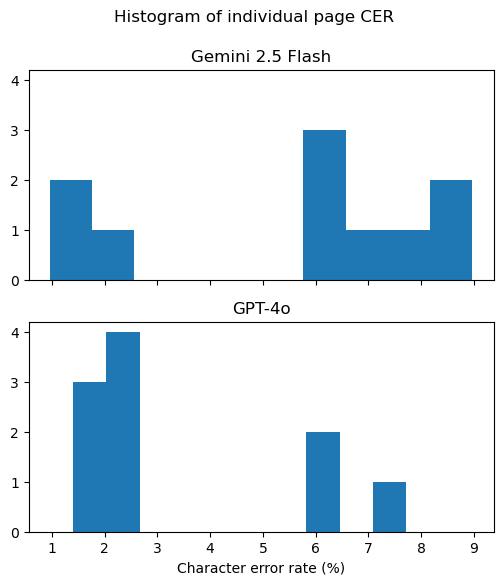

In [38]:
# Compare error rates of different models/methods
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True, sharey=True)
fig.suptitle('Histogram of individual page CER')
ax0.hist(cer_pct['gemini-2.5-flash'])
ax0.set_title('Gemini 2.5 Flash')
ax1.hist(cer_pct['gpt-4o'])
ax1.set_title('GPT-4o')
ax1.set_xlabel('Character error rate (%)')